In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import os
import pickle
import json

from tqdm import tqdm_notebook
from scipy.io import wavfile
from copy import deepcopy

### Prepare Loaders

In [2]:
#path_dataset = '../input/'
path_dataset = '/home/edoardobucheli/Datasets/FSDKaggle2018'

path_train = os.path.join(path_dataset,'audio_train_16k')
path_test = os.path.join(path_dataset,'audio_test_16k')

### Load Label Data

In [3]:
train_data = pd.read_csv(os.path.join(path_dataset,'train_post_competition.csv'))
test_data = pd.read_csv(os.path.join(path_dataset,'test_post_competition_scoring_clips.csv'))

In [4]:
from utilities import get_all_classes_dict, get_classes_to_meta_dict, get_labels

In [5]:
num_to_label, label_to_num, n_classes = get_all_classes_dict(train_data)
label_to_meta, label_num_to_meta = get_classes_to_meta_dict(label_to_num)

In [6]:
data_cur = train_data[train_data['manually_verified']==1]
data_noi = train_data[train_data['manually_verified']==0]

In [7]:
meta_labels_all, labels_all = get_labels(train_data,label_to_meta, label_to_num)
meta_labels_cur, labels_cur = get_labels(data_cur,label_to_meta, label_to_num)
meta_labels_noi, labels_noi = get_labels(data_noi,label_to_meta, label_to_num)
meta_labels_test, labels_test = get_labels(test_data,label_to_meta, label_to_num)

In [8]:
n_meta_classes = len(np.unique(meta_labels_all))

### Load Data

In [9]:
pickle_train = './preprocessed_train/MS-80-HL512-WF16k-64k'
pickle_test = './preprocessed_test/MS-80-HL512-WF16k-64k'

In [10]:
with open(pickle_train,'rb') as fp:
    x_train = pickle.load(fp)
with open(pickle_test, 'rb') as fp:
    x_test = pickle.load(fp)

In [11]:
sr = 16000
file_length = 64000
hop_length = 512
n_mels = 80

frames = int(np.ceil(file_length/hop_length))

### Load Network

In [12]:
from CNNetworks2D import malley_cnn_80
from tensorflow.keras.optimizers import Adam

In [13]:
input_shape = ([n_mels,frames])
lr = 0.001
model_41 = malley_cnn_80(input_shape,n_classes)
model_41.compile(optimizer=Adam(lr),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
#model_41.save_weights('./weights_mc_malley.h5')
#model_41.load_weights('./weights_mc_malley.h5')
#model_41.summary()

### Setup Generator

In [14]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self,x_set,y_set,
                 batch_size = 128,input_shape = (80,frames),
                 n_classes=80, sr = 44100, seconds = 4):
        
        self.x, self.y = x_set,y_set
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.sr = sr
        self.file_length = sr*seconds
        #self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.x)/self.batch_size))
    
    def __getitem__(self,idx):
        
        spects = self.x[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
        
        batch_x = self.__generate_data(spects)
        
        #print(batch_x.shape)
        #print(batch_y.shape)
        
        return batch_x,batch_y
    
    def __generate_data(self,spects):
        n_mels,frames = self.input_shape
        x_batch = np.zeros((len(spects),n_mels,frames))
        
        for i, spect in enumerate(spects):
            freq_res,time_res = spect.shape
            
            max_start = time_res-frames
            if max_start == 0:
                start = 0
            else:
                start = np.random.randint(0,max_start)
            end = start+frames
            
            x_batch[i] = spect[:,start:end]
        
        return x_batch

### Split Dataset

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train_a,X_val_a,y_train_a,y_val_a = train_test_split(x_train,labels_all,test_size=0.1, random_state=7)

In [17]:
train_generator_a = DataGenerator(X_train_a,y_train_a)
val_generator_a = DataGenerator(X_val_a,y_val_a)

### Train Model

In [18]:
model_41.fit_generator(train_generator_a,epochs = 50,validation_data=val_generator_a)

Epoch 1/50
67/67 [==============================] - 20s 301ms/step - loss: 3.2279 - acc: 0.1237 - val_loss: 2.6726 - val_acc: 0.2563
Epoch 2/50
67/67 [==============================] - 16s 241ms/step - loss: 2.4238 - acc: 0.3009 - val_loss: 2.0614 - val_acc: 0.4146
Epoch 3/50
67/67 [==============================] - 16s 232ms/step - loss: 1.9318 - acc: 0.4377 - val_loss: 1.6966 - val_acc: 0.5011
Epoch 4/50
67/67 [==============================] - 14s 209ms/step - loss: 1.6413 - acc: 0.5231 - val_loss: 1.4971 - val_acc: 0.5707
Epoch 5/50
67/67 [==============================] - 15s 231ms/step - loss: 1.4525 - acc: 0.5761 - val_loss: 1.3354 - val_acc: 0.6097
Epoch 6/50
67/67 [==============================] - 16s 241ms/step - loss: 1.2772 - acc: 0.6247 - val_loss: 1.2675 - val_acc: 0.6350
Epoch 7/50
67/67 [==============================] - 16s 241ms/step - loss: 1.1687 - acc: 0.6598 - val_loss: 1.2424 - val_acc: 0.6414
Epoch 8/50
67/67 [==============================] - 17s 254ms/step - 

In [29]:
model_41.save_weights('./weights_m41.h5')

### Make Inference

In [30]:
from utilities import create_quick_test

In [31]:
x_test_2 = create_quick_test(x_test,1600,80,125)

In [32]:
model_41.evaluate(x_test_2,labels_test)

1600/1600 [==============================] - 1s 618us/step


[1.4952516198158263, 0.74625]

In [23]:
y_scores = model_41.predict(x_test_2)

In [24]:
y_hat = np.argmax(y_scores, axis = 1)

In [25]:
#del(mc_model)

### Plot Confusion Matrix

In [26]:
from utilities import plot_cm

In [27]:
labels = list(label_to_num.keys())

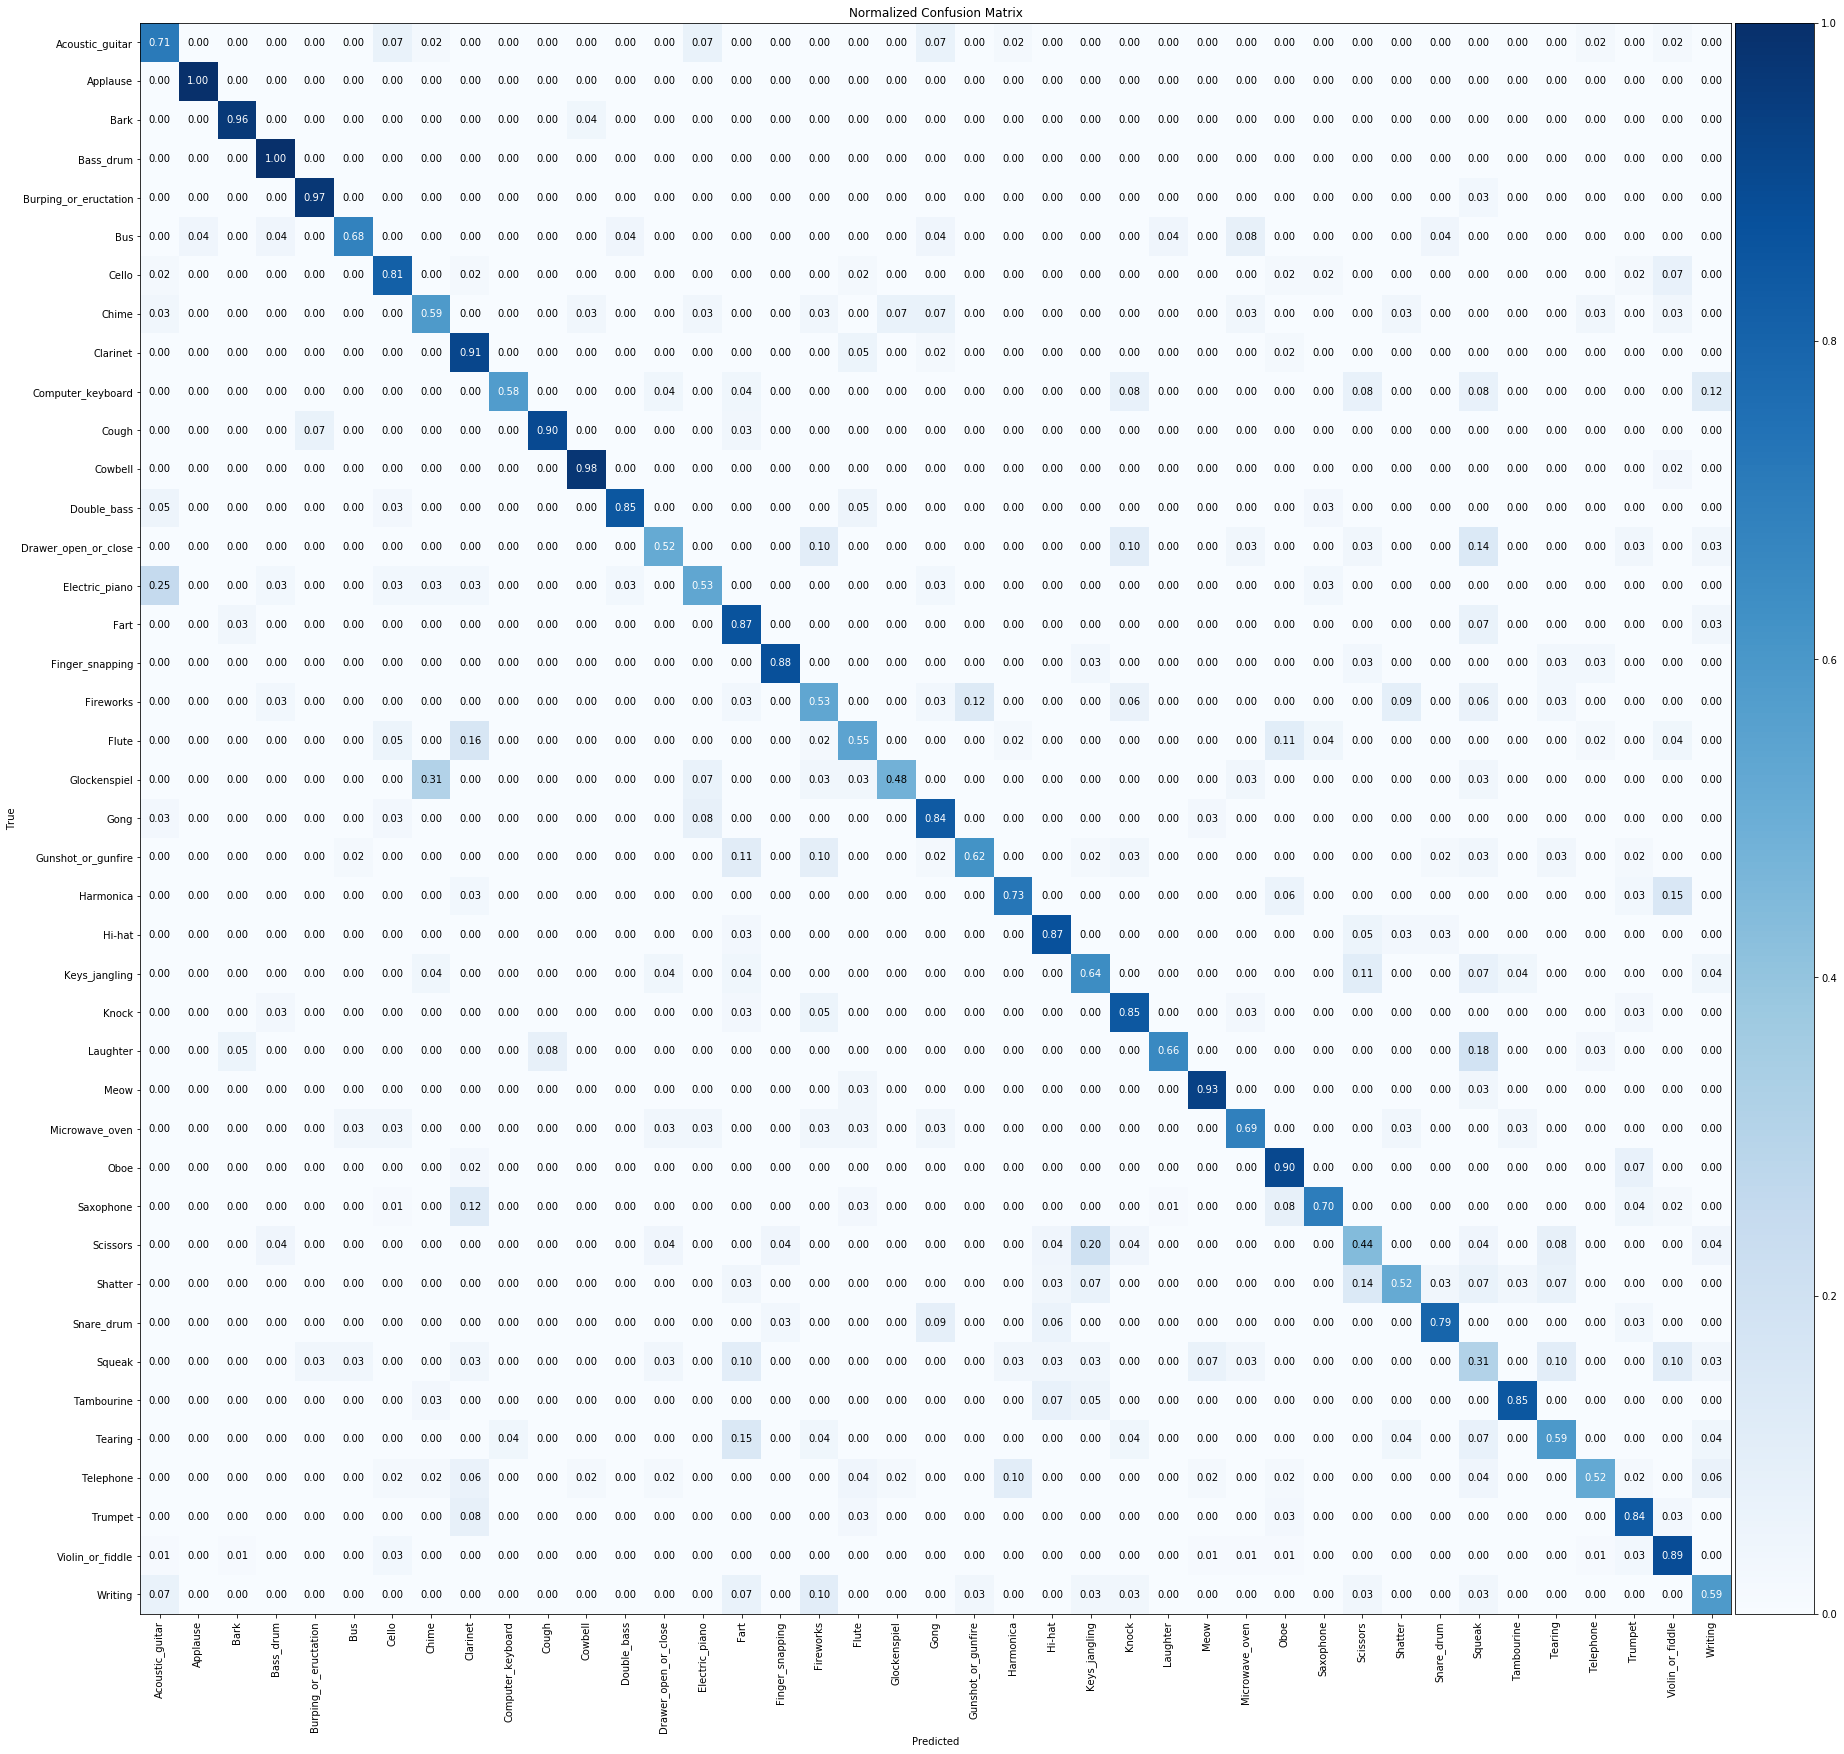

In [28]:
plot_cm(labels_test,y_hat,figsize = (30,30), labels = labels, xrotation = 90)
plt.savefig('./cm_41classes.eps')